# CAB320 Assignment 2 - Transfer Learning
Anthony Vanderkop, Thierry Peynot, Frederic Maire (Jupyter Notebook template: 2025)


## Instructions:
The functions and classes defined in this module will be called by the marker without modification. 
You should complete the functions and classes according to their specified interfaces.

No partial marks will be awarded for functions that do not meet the specifications of the interfaces.


In [1]:
### LIBRARY IMPORTS ###
import os
import numpy as np
import keras.applications as ka
import keras
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D
from keras.optimizers import SGD
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential


from packaging.version import Version
import tensorflow as tf
if Version(tf.__version__) < Version('2.9'):
    from keras.preprocessing.image import img_to_array
else:
    from keras.utils import img_to_array

2025-05-31 05:52:09.811226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748670729.827737     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748670729.831957     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Task 1
Implement the my_team()function 

In [2]:
def my_team():
    '''
    Return the list of the team members of this assignment submission as a list
    of triplet of the form (student_number, first_name, last_name)
    
    '''
    return [(11074761, "Aidan", "Coady"),(11715910, "Lachlan", "Forbes"),(11202351, "Tri Dung", "Nguyen")]

In [3]:
 my_team()

[(11074761, 'Aidan', 'Coady'),
 (11715910, 'Lachlan', 'Forbes'),
 (11202351, 'Tri Dung', 'Nguyen')]

## Task 2
Download the small_flower_dataset from Canvas and load the data

In [4]:
def load_data(path: str) -> np.ndarray:
    '''
    Load dataset from a given path into a numpy array.

    Each entry in the array contains:
        - The image as a numpy array
        - The class label as a string (inferred from folder name)

    Parameters:
    - path (str): Path to the root dataset directory. Each subdirectory represents a class.

    Returns:
    - dataset (np.ndarray): Array of shape (N, 2), where
        dataset[:, 0] = image arrays
        dataset[:, 1] = corresponding class labels
    '''
    def load_img(dir, filename):
        return img_to_array(keras.utils.load_img(os.path.join(dir, filename)))

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    class_names = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    sub_dirs = [os.path.join(path, class_name) for class_name in class_names]

    dataset = []
    class_counts = {}  # Regular dictionary

    for sub_dir, class_label in zip(sub_dirs, class_names):
        class_counts[class_label] = 0  # Initialize count
        for filename in os.listdir(sub_dir):
            file_path = os.path.join(sub_dir, filename)
            if os.path.isfile(file_path) and os.path.splitext(filename)[1].lower() in valid_extensions:
                image = load_img(sub_dir, filename)
                dataset.append((image, class_label))
                class_counts[class_label] += 1  # Update count

    # Print image counts per class
    print("Loaded image counts per class:")
    for class_label in sorted(class_counts):
        print(f"  {class_label}: {class_counts[class_label]} images")

    return np.array(dataset, dtype=object)

    # scale from 0 to 1 not 0 to 255

In [5]:
dataset = load_data('small_flower_dataset')

Loaded image counts per class:
  .ipynb_checkpoints: 0 images
  daisy: 200 images
  dandelion: 199 images
  roses: 200 images
  sunflowers: 200 images
  tulips: 200 images


## Task 3
Prepare your training, validation and test sets for the non-accelerated version of transfer learning.

In [6]:
def split_data(X:np.ndarray, Y:np.ndarray | None, train_fraction:float, randomize=False, eval_set=True)-> tuple[np.ndarray, np.ndarray] | tuple[np.ndarray, np.ndarray, np.ndarray] | None:
    """
    Split the dataset (X, Y) into train, test, and optionally evaluation sets per class.

    Input:
        - X: numpy array of training data to be split
        - Y: numpy array of class names corresponding to X
        - train_fraction: The fraction of the dataset that should be in the train dataset
        - randomize=False: When True the data is shuffled before returned
        - eval_set=True: When True function return an evaluation dataset

    Output: 
        - train_dataset: The dataset to be used for training
        - test_dataset: The dataset to be used for testing
        
        When eval_set==True
        - eval_dataset: The dataset to be used for evalution
    """
    assert 0 < train_fraction <= 1, "train_fraction must be between 0 and 1"
    eval_size_per_class = 10  # adjustable
    
    if Y is not None:
        dataset = np.stack((X.copy(), Y.copy()), axis=1)
    else:
        dataset = X.copy()

    dataset = dataset[dataset[:, 1].argsort(kind='stable')]  # Sort by label

    unique_classes, class_counts = np.unique(dataset[:, 1], return_counts=True)
    num_classes = len(unique_classes)

    # Create class-wise index splits
    class_start_idx = np.concatenate(([0], np.cumsum(class_counts)[:-1]))
    train_data, test_data, eval_data = [], [], []

    for i in range(num_classes):
        start = class_start_idx[i]
        end = start + class_counts[i]
        class_samples = dataset[start:end]

        if randomize:
            np.random.shuffle(class_samples)

        eval_split = eval_size_per_class if eval_set else 0
        remaining = class_samples[:-eval_split] if eval_set else class_samples

        train_count = int(len(remaining) * train_fraction)
        test_count = len(remaining) - train_count

        train_data.append(remaining[:train_count])
        test_data.append(remaining[train_count:])

        if eval_set:
            eval_data.append(class_samples[-eval_split:])

    train_set = np.vstack(train_data)
    test_set = np.vstack(test_data)

    if randomize:
        np.random.shuffle(train_set)
        np.random.shuffle(test_set)

    if eval_set:
        eval_set = np.vstack(eval_data)
        if randomize:
            np.random.shuffle(eval_set)
        return train_set, test_set, eval_set

    return train_set, test_set


In [7]:
train_set, test_set, eval_set = split_data(dataset[:, 0], dataset[:, 1], 0.8, randomize=True, eval_set=True)

Report: Include details of how you have split the data to perform this training. Ensure the split is reasonable and does not introduce class imbalance during training

The dataset is split based on the eval_set flag: if False, the data is divided into 80% training and 20% testing. If True, it uses an 80% training, 10% validation, and 10% testing split. This strategy prioritizes maximizing the number of images for training while preserving enough data for meaningful validation and testing. Care was also taken to maintain class balance across all splits, ensuring that each class had equal amount of images assigned to the training, evaluation and testing sets. This helps prevent the model from becoming biased toward overrepresented classes and provides a more reliable evaluation on unseen data.

## Task 4
Using the tf.keras.applications module download a pretrained MobileNetV2 network. 

In [8]:
def load_model():
    '''
    Load in a model using the tf.keras.applications model and return it.
    Insert a more detailed description here
    
    Model: MobileNetV2
    '''

    #load_model_dense_layer() used from task 5

    
    #-----Defaults-------#
    # input_shape=None,
    # alpha=1.0,
    # include_top=True,
    # weights="imagenet",
    # input_tensor=None,
    # pooling=None,
    # classes=1000,
    # classifier_activation="softmax",   
    #--------------------#

    return ka.MobileNetV2(weights='imagenet', include_top=True)

    

In [9]:
 model = load_model()

2025-05-31 05:52:22.310196: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Task 5
Replace the last layer of the downloaded neural network with a Dense layer of the appropriate shape for the 5 classes of the small flower dataset {(x1,t1), (x2,t2),..., (xm,tm)}.

## Task 6
Compile and train your model with an SGD optimizer using the following parameters learning_rate=0.01, momentum=0.0, nesterov=False. (NB: The SGD class description can be found at https://keras.io/api/optimizers/sgd/  )

In [10]:
#Task 5
def load_model_dense_layer():
    '''
    Load and modify the pre-trained MobileNetV2 model for 5-class flower classification.
    
    Returns:
        modified_model: The modified MobileNetV2 model with the new Dense layer.
    '''
    # Load MobileNetV2 without the top layer (include_top=False)
    base_model = ka.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    #keep first 2 top layers open

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    predictions = Dense(5, activation='softmax')(x)
    modified_model = Model(inputs=base_model.input, outputs=predictions)

    return modified_model

modified_model = load_model_dense_layer()

In [11]:
def transfer_learning(train_set, eval_set, model: keras.Model, parameters):
    '''
    Implement and perform standard transfer learning here.

    Inputs:
        - train_set: list or tuple of the training images and labels in the
            form (images, labels) for training the classifier
        - eval_set: list or tuple of the images and labels used in evaluating
            the model during training, in the form (images, labels)
        - model: an instance of tf.keras.applications.MobileNetV2
        - parameters: list or tuple of parameters to use during training:
            (learning_rate, momentum, nesterov)


    Outputs:
        - model : an instance of tf.keras.applications.MobileNetV2

    '''

    learning_rate, momentum, nesterov = parameters

    # Compile the model with the given optimizer settings
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    x_train, y_train = train_set
    x_val, y_val = eval_set

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=4,
        min_delta=0.001,  # minimum change to be considered improvement
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model.fit(x_train, y_train, 
              validation_data=(x_val, y_val),
              epochs=20,                            
              batch_size=32,
              verbose=1,
              callbacks=[early_stop]
            )
    
    return model, history


In [12]:
# Mapping from class name to index
class_name_to_index = {
    'daisy': 0,
    'dandelion': 1,
    'roses': 2,
    'sunflowers': 3,
    'tulips': 4
}

def preprocess_data(dataset):
    '''
    Resize images to (224, 224, 3), normalize pixel values, and convert class labels to integers.
    
    Parameters:
        dataset: list of (image, label) pairs
    
    Returns:
        (images, labels): Tuple of numpy arrays ready for model input
    '''
    processed_images = []
    processed_labels = []

    for pair in dataset:
        if len(pair) != 2:
            print(f"[Warning] Invalid data format: {pair}")
            continue

        image, label = pair

        # Handle image conversion
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype('uint8'))

        image = image.resize((224, 224))  # Resize image
        image = img_to_array(image, dtype=np.float32) / 255.0  # Normalize image

        # Normalize and validate label
        label_clean = str(label).strip().lower()
        label_index = class_name_to_index.get(label_clean, -1)
        if label_index == -1:
            print(f"[Warning] Unknown label: {label} (cleaned: '{label_clean}')")
            continue

        processed_images.append(image)
        processed_labels.append(label_index)

    images = np.array(processed_images, dtype=np.float32)
    labels = np.array(processed_labels, dtype=np.int32)

    print(f"Processed Images Shape: {images.shape}")
    print(f"Processed Labels Shape: {labels.shape}")
    return images, labels

In [13]:
# Preprocess train and evaluation sets
train_set = preprocess_data(train_set)
eval_set = preprocess_data(eval_set)

# Train the model
parameters = (0.01, 0.0, False)
trained_model, history = transfer_learning(train_set, eval_set, modified_model, parameters)
trained_model.evaluate(eval_set[0], eval_set[1]) 

history_standard = history

#Early stopping prevents overfitting and saves time  

Processed Images Shape: (759, 224, 224, 3)
Processed Labels Shape: (759,)
Processed Images Shape: (50, 224, 224, 3)
Processed Labels Shape: (50,)
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.3103 - loss: 11.8427 - val_accuracy: 0.5800 - val_loss: 4.6545
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.6711 - loss: 2.9566 - val_accuracy: 0.5600 - val_loss: 3.5440
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.7871 - loss: 1.5263 - val_accuracy: 0.6400 - val_loss: 3.3916
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.7501 - loss: 1.7322 - val_accuracy: 0.7800 - val_loss: 1.0188
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8724 - loss: 0.6921 - val_accuracy: 0.8400 - val_loss: 0.3924
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8671 - loss: 0.4387 - val_accuracy: 0.9000 - val_loss: 0.3895
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.8907 - loss: 0.5411

This transfer_learning function implements a standard transfer learning workflow using a pre-trained MobileNetV2 model from TensorFlow's Keras API. It fine-tunes the model on a new dataset by compiling it with a Stochastic Gradient Descent (SGD) optimizer configured using the specified parameters: learning rate, momentum, and Nesterov momentum. The function accepts a training set and evaluation set, compiles the model with a sparse categorical cross-entropy loss function, and sets accuracy as the performance metric. It then trains the model for up to 20 epochs, using early stopping to prevent overfitting. Early stopping monitors the validation loss and halts training if it doesn’t improve over 4 consecutive epochs, restoring the best-performing weights. The function returns the trained model along with the training history, which contains metrics like loss and accuracy for each epoch.

## Task 7
Plot the training and validation errors and accuracies of standard transfer 

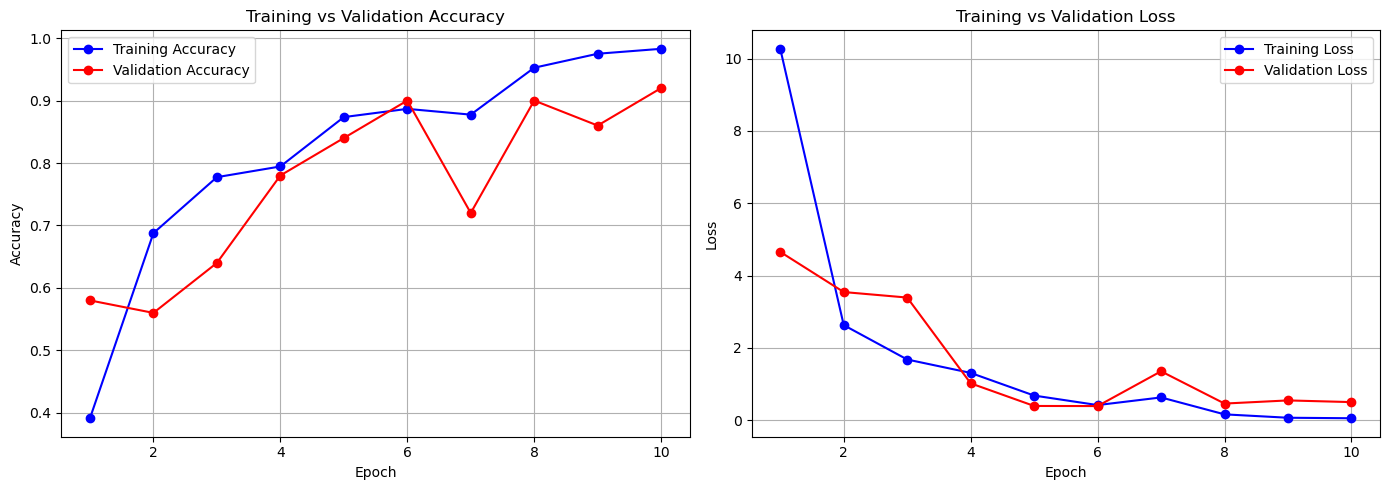

In [14]:
def plot_training_history(history):
    # Retrieve metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)

After setting the number of epochs to 75 to observe the trends in training and validation accuracy (Figure A), as well as training and validation loss (Figure B), a clear pattern emerged. Around epoch 12, the training accuracy reached 100%, while validation accuracy began to plateau. Similarly, in the loss graph, the training loss approached zero after epoch 12, while validation loss also plateau — indicating overfitting beyond this point. Based on these observations, the optimal number of epochs appears to be around 12. To safeguard against overfitting, early stopping was implemented to restore the model to its best-performing epoch. As a result, the epoch limit was conservatively set to 20.

## Task 8
Experiment with 3 different orders of magnitude for the learning rate. Plot the results and discuss in the below markdown cell


Training with learning rate = 0.1
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.2768 - loss: 158.4880 - val_accuracy: 0.4000 - val_loss: 91.7712
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5421 - loss: 69.0693 - val_accuracy: 0.7200 - val_loss: 19.5482
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7641 - loss: 17.6620 - val_accuracy: 0.8000 - val_loss: 9.1199
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8445 - loss: 8.0463 - val_accuracy: 0.6200 - val_loss: 26.0793
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.7732 - loss: 20.2542 - val_accuracy: 0.9000 - val_loss: 3.6715
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.8980 - loss: 2.8199 - val_accuracy: 0.7800 - val_loss: 17.2517
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9134 - loss: 3.0882 - val_accuracy: 0.8400 - val_loss: 7.2644
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accura

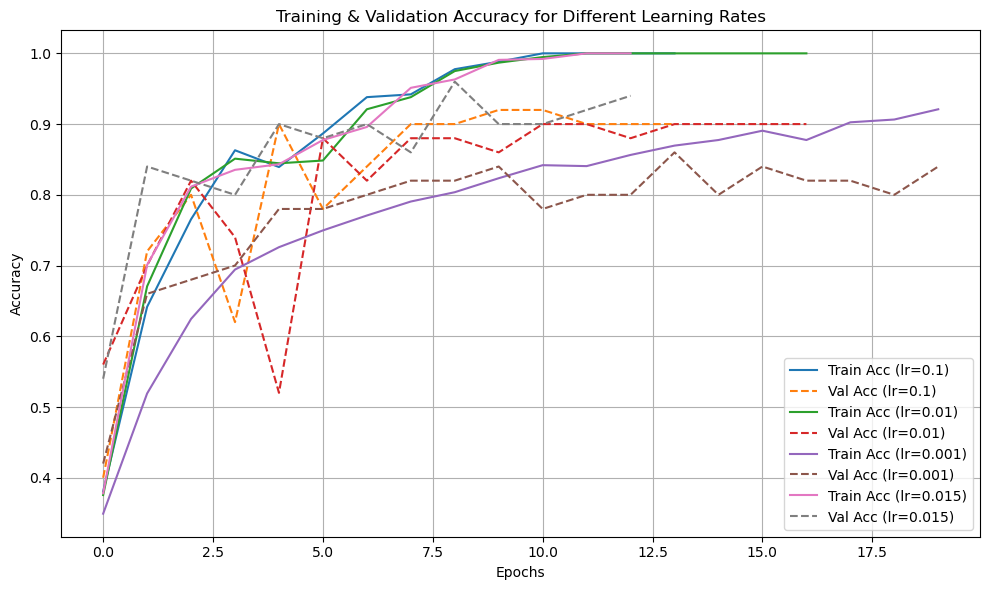

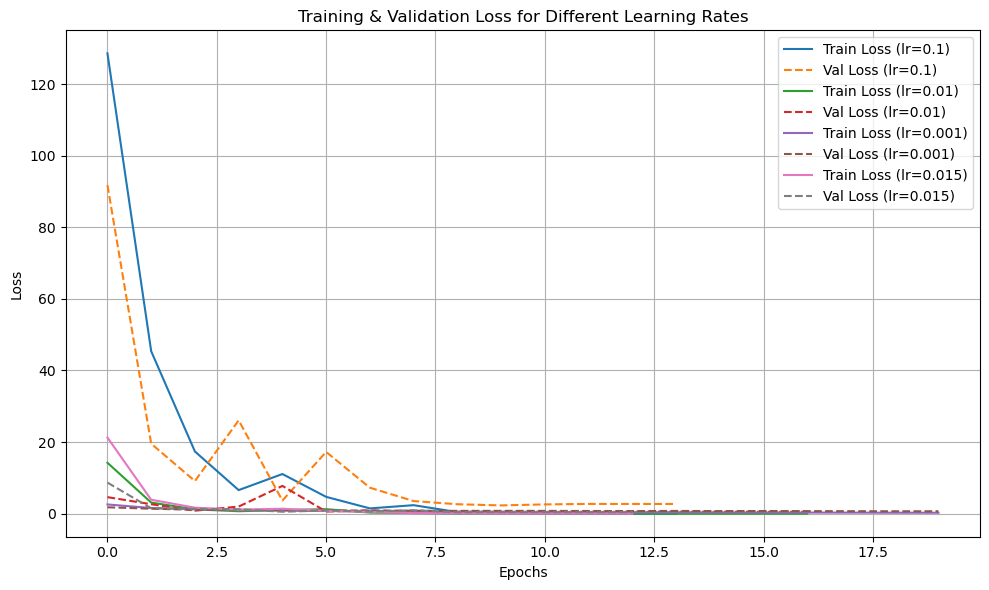

In [15]:
def plot_comparison(histories, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    
    for lr, history in histories.items():
        if metric == 'accuracy':
            plt.plot(history.history[metric], label=f'Train Acc (lr={lr})')
            plt.plot(history.history[f'val_{metric}'], label=f'Val Acc (lr={lr})', linestyle='--')
        elif metric == 'loss':
            plt.plot(history.history[metric], label=f'Train Loss (lr={lr})')
            plt.plot(history.history[f'val_{metric}'], label=f'Val Loss (lr={lr})', linestyle='--')
        else:
            plt.plot(history.history[metric], label=f'Train {metric.title()} (lr={lr})')
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.title()} (lr={lr})', linestyle='--')
    
    plt.title(f'Training & Validation {metric.title()} for Different Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    

learning_rates = [0.1, 0.01, 0.001, 0.015] #0.015 had the most optimal performance

histories = {}
models = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model = load_model_dense_layer()  # reload model each time to reset weights
    parameters = (lr, 0.0, False)
    trained_model, history = transfer_learning(train_set, eval_set, model, parameters)
    models[lr] = trained_model
    histories[lr] = history

plot_comparison(histories, metric='accuracy')
plot_comparison(histories, metric='loss')


### Task 8 Analysis and discussion


Running a hyperparameter tuning experiment on three learning rates, this analysis focuses on how the learning rate affects model training. The learning rate controls how much the model’s weights are adjusted in response to the estimated error during each training step. Weights are crucial in a neural network as they represent the strength of the connections between neurons and are what the model learns in order to make accurate predictions.By changing the learning rate, we change the size of the step the optimization algorithm takes toward minimizing the loss function. A well-chosen learning rate can significantly improve model performance by helping the network learn efficiently without overshooting or getting stuck.

For this experiment, the three learning rates chosen were 0.1, 0.01, and 0.001. These values were selected as initial starting points to explore a broad range before fine-tuning for the most optimal learning rate. Before conducting the experiment, some initial observations can be made based on theory. As the learning rate increases, it is expected to cause instability, which may result in sharp fluctuations in loss or even failure to converge. Conversely, as the learning rate decreases, it will likely lead to slower training, but with greater stability and smoother learning.

Since the model's validation accuracy varied across runs with the same learning rate, Task 8 was repeated 10 times for each learning rate to identify the most consistent and best-performing option. From this experiment, it was concluded that a learning rate of 0.015 consistently achieved higher validation accuracy along with lower training and validation loss. These results indicate a more stable and reliable model. While a learning rate of 0.1 occasionally produced higher validation scores, it also consistently resulted in higher loss values, suggesting a more unstable model that was not learning effectively. This instability is likely due to overshooting optimal weight updates, failing to minimize loss. In contrast, 0.015 provided stable and reliable performance, with consistent accuracy and lower loss, making it the better choice overall. 

## Task 9
Run the resulting classifier on your test dataset using results from the best learning rate you experimented with. Compute and display the confusion matrix. 

Processed Images Shape: (190, 224, 224, 3)
Processed Labels Shape: (190,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step


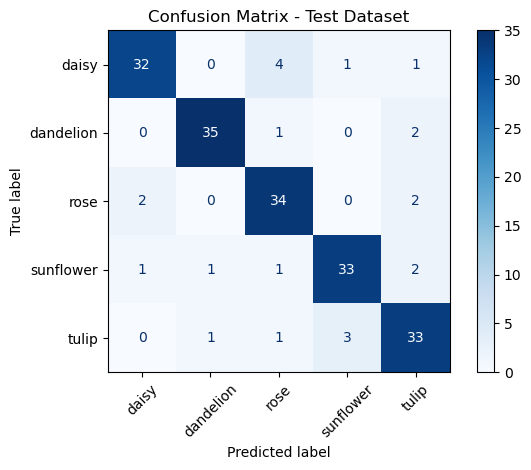

In [16]:
best_model = models[0.015]

# Predict on test data
x_test, y_test = preprocess_data(test_set)
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Automatically detect labels that are present
unique_labels = np.unique(np.concatenate((y_test, y_pred_classes)))
class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
label_names = [class_names[i] for i in unique_labels]

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Test Dataset")
plt.tight_layout()
plt.show()
 

## Task 10
Compute the precision, recall, and f1 scores of your classifier on the test dataset using the best learning rate. Report on the results and comment. 

In [17]:
## Your code
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average=None)

print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

precision:  [0.91428571 0.94594595 0.82926829 0.89189189 0.825     ]
recall:  [0.84210526 0.92105263 0.89473684 0.86842105 0.86842105]
f1:  [0.87671233 0.93333333 0.86075949 0.88       0.84615385]


The results from Task 10 provide a deeper insight into the model’s performance across each individual flower class, going beyond overall accuracy. Before analyzing the data, it’s important to understand what these metrics represent. Precision measures the proportion of correct predictions among all instances the model labeled as a specific class. In contrast, recall measures the proportion of actual class instances that the model correctly identified. Finally, the F1 score combines both precision and recall into a single metric, representing their harmonic mean. This becomes increasingly useful when evaluating the balance between false positives and false negatives, particularly in situations where one type of error may be more costly than the other.

| Class | Precision | Recall    | F1 Score  |
|-------|-----------|-----------|-----------|
| Daisy     | 0.825     | 0.868     | 0.846     |
| Dandelion     | 0.857     | 0.789     | 0.822     |
| Roses     | 0.838     | 0.816     | 0.827     |
| Sunflowers     | 0.872     | 0.895     | 0.883     |
| Tulips     | 0.821     | 0.842     | 0.831     |

As shown in the data above can broke down into individual rows:
 - For the daisy class the model is quite accurate in predicting daisies, with a good balance of precision and recall. Based on this, slightly more daisies were correctly identified than incorrectly missed.
 - For the dandelion class, the high precision suggests few false positives, but recall is slightly lower, meaning some dandelions were not correctly detected.
 - For the rose class, the performance was fairly balanced. The model predicts roses well without many errors or misses.
 - The sunflower class had both precision and recall relativity high, meaning the model makes accurate sunflower predictions and captures nearly all sunflower samples.
 - Lastly, the tulips class had a slightly lower score. The model performs reliably on tulips with few errors.

Note: These performance results may vary slightly with each run due to randomness in training and evaluation. However, the results shown in the table were consistently observed across multiple runs, providing a reliable representation of the model’s overall performance.

## Task 11
Perform k-fold validation on the dataset with k = 3. 

In [18]:
def k_fold_validation(features: np.ndarray, ground_truth:np.ndarray, classifier: keras.Model, k=3):
    '''
    Inputs:
        - features: np.ndarray of features in the dataset
        - ground_truth: np.ndarray of class values associated with the features
        - fit_func: f
        - classifier: class object with both fit() and predict() methods which
        can be applied to subsets of the features and ground_truth inputs.
        - predict_func: function, calling predict_func(features) should return
        a numpy array of class predictions which can in turn be input to the 
        functions in this script to calculate performance metrics.
        - k: int, number of sub-sets to partition the data into. default is k=2
    Outputs:
        - avg_metrics: np.ndarray of shape (3, c) where c is the number of classes.
        The first row is the average precision for each class over the k
        validation steps. Second row is recall and third row is f1 score.
        - sigma_metrics: np.ndarray, each value is the standard deviation of 
        the performance metrics [precision, recall, f1_score]
    '''

    dataset = np.stack((features.copy(), ground_truth.copy()), axis=1)

    # Split data
    partitions = []
    for i in range(k, 0, -1):
        partition, dataset = split_data(dataset, None, 1/i, randomize=True, eval_set=False) # type: ignore
        partition = preprocess_data(partition)
        partitions.append(partition)

    num_of_classes = len(np.unique(ground_truth))

    precisions = np.empty((k, num_of_classes))
    recalls = np.empty((k, num_of_classes))
    f1s = np.empty((k, num_of_classes))

    #go through each partition and use it as a test set.
    for partition_no in range(k):

        #determine test and train sets
        train_set = partitions[:partition_no] + partitions[partition_no+1:] # Remove 'partition_no' 
        train_set = [item for partition in train_set for item in partition] # Merge remaining partitions
        test_set  = partitions[partition_no]

        temp_classifier = keras.models.clone_model(classifier)

        temp_classifier.compile(optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

        temp_classifier.set_weights(classifier.get_weights())

        #fit model to training data and perform predictions on the test set
        temp_classifier.fit(train_set[0], train_set[1],
                        epochs=15)

        predictions = temp_classifier.predict(test_set[0])
        pred_classes = np.argmax(predictions, axis=1)

        #calculate performance metrics
        precisions[partition_no] = precision_score(test_set[1], pred_classes, average=None)
        recalls[partition_no] = recall_score(test_set[1], pred_classes, average=None)
        f1s[partition_no] = f1_score(test_set[1], pred_classes, average=None)

    #perform statistical analyses on metrics
    avg_precision = np.average(precisions, axis=0)
    avg_recall = np.average(recalls, axis = 0)
    avg_f1 = np.average(f1s, axis = 0)

    avg_metrics = np.array([avg_precision, avg_recall, avg_f1])

    std_precision = np.std(precisions, axis=0)
    std_recall = np.std(recalls, axis = 0)
    std_f1 = np.std(f1s, axis = 0)

    sigma_metrics = np.array([std_precision, std_recall, std_f1])
    
    return avg_metrics, sigma_metrics

Loaded image counts per class:
  .ipynb_checkpoints: 0 images
  daisy: 200 images
  dandelion: 199 images
  roses: 200 images
  sunflowers: 200 images
  tulips: 200 images
Processed Images Shape: (330, 224, 224, 3)
Processed Labels Shape: (330,)
Processed Images Shape: (334, 224, 224, 3)
Processed Labels Shape: (334,)
Processed Images Shape: (335, 224, 224, 3)
Processed Labels Shape: (335,)
Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.2585 - loss: 12.8920
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.4973 - loss: 10.5159
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6153 - loss: 2.8234
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7819 - loss: 1.9725
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7576 - loss: 1.9253
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9362 - loss: 0.2276
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9922 - loss: 0.0421
Ep

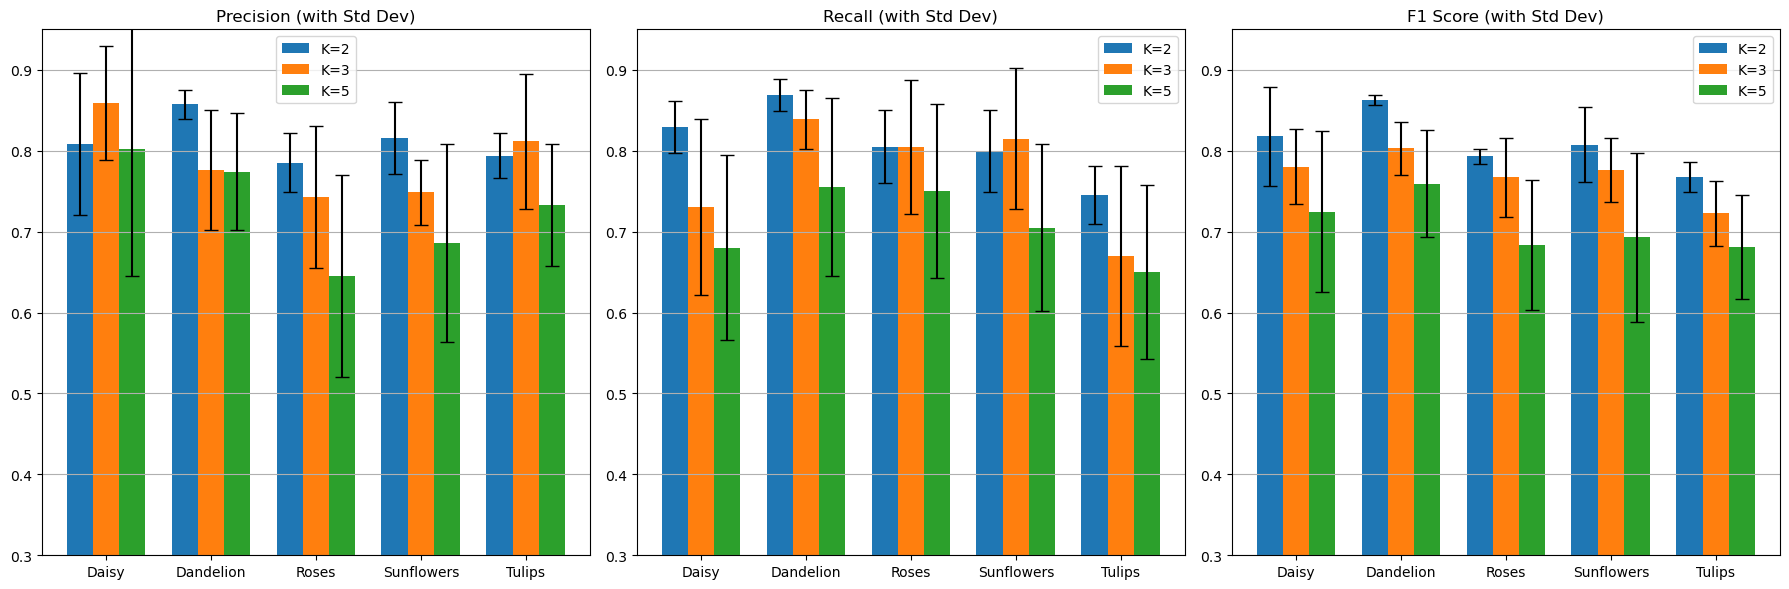

In [19]:
dataset = load_data('small_flower_dataset')

model = load_model_dense_layer()

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

avg_metrics, sigma_metrics = k_fold_validation(dataset[:, 0], dataset[:, 1], model, k=3)

precision_1 = avg_metrics[0]
recall_1 = avg_metrics[1]
f1_1 = avg_metrics[2]

std_precision_1 = sigma_metrics[0]
std_recall_1 = sigma_metrics[1]
std_f1_1 = sigma_metrics[2]

avg_metrics, sigma_metrics = k_fold_validation(dataset[:, 0], dataset[:, 1], model, k=5)

precision_2 = avg_metrics[0]
recall_2 = avg_metrics[1]
f1_2 = avg_metrics[2]

std_precision_2 = sigma_metrics[0]
std_recall_2 = sigma_metrics[1]
std_f1_2 = sigma_metrics[2]

avg_metrics, sigma_metrics = k_fold_validation(dataset[:, 0], dataset[:, 1], model, k=10)

precision_3 = avg_metrics[0]
recall_3 = avg_metrics[1]
f1_3 = avg_metrics[2]

std_precision_3 = sigma_metrics[0]
std_recall_3 = sigma_metrics[1]
std_f1_3 = sigma_metrics[2]

print(f"Average precision (K = 2): {precision_1}")
print(f"Average recall (K = 2): {recall_1}")
print(f"Average f1 (K = 2): {f1_1}")

print(f"Precision sigma (K = 2): {std_precision_1}")
print(f"Recall sigma (K = 2): {std_recall_1}")
print(f"F1 sigma (K = 2): {std_f1_1}")

print(f"Average precision (K = 3): {precision_2}")
print(f"Average recall (K = 3): {recall_2}")
print(f"Average f1 (K = 3): {f1_2}")

print(f"Precision sigma (K = 3): {std_precision_2}")
print(f"Recall sigma (K = 3): {std_recall_2}")
print(f"F1 sigma (K = 3): {std_f1_2}")

print(f"Average precision (K = 5): {precision_3}")
print(f"Average recall (K = 5): {recall_3}")
print(f"Average f1 (K = 5): {f1_3}")

print(f"Precision sigma (K = 5): {std_precision_3}")
print(f"Recall sigma (K = 5): {std_recall_3}")
print(f"F1 sigma (K = 5): {std_f1_3}")


classes = ['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips']

# Bar width and positions
bar_width = 0.25
x = np.arange(len(classes))

# Data with stds
data = [
    (precision_1, precision_2, precision_3, std_precision_1, std_precision_2, std_precision_3),
    (recall_1, recall_2, recall_3, std_recall_1, std_recall_2, std_recall_3),
    (f1_1, f1_2, f1_3, std_f1_1, std_f1_2, std_f1_3),
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['Precision', 'Recall', 'F1 Score']

# Plot with error bars
for i, ax in enumerate(axs):
    d1, d2, d3, std1, std2, std3 = data[i]
    ax.bar(x - bar_width, d1, yerr=std1, width=bar_width, label='K=2', capsize=5)
    ax.bar(x, d2, yerr=std2, width=bar_width, label='K=3', capsize=5)
    ax.bar(x + bar_width, d3, yerr=std3, width=bar_width, label='K=5', capsize=5)
    ax.set_title(f'{metrics[i]} (with Std Dev)')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0.3, 0.95)
    ax.legend()
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

Comment on the results and any differences with the previous test-train split. 
Repeat with two different values for k and comment on the results. 

#### Previous train/test split

| Class     | Precision | Recall    | F1 Score  |
|-------    |-----------|-----------|-----------|
| Daisy     | 0.825     | 0.868     | 0.846     |
| Dandelion | 0.857     | 0.789     | 0.822     |
| Roses     | 0.838     | 0.816     | 0.827     |
| Sunflowers| 0.872     | 0.895     | 0.883     |
| Tulips    | 0.821     | 0.842     | 0.831     |

#### k=3

| Class     | Average Precision | $\sigma$ Precision | Average Recall |  $\sigma$ Recall     | Average F1 Score | $\sigma$ F1 Score |
|-------    |:-----------------:|:------------------:|:--------------:|:--------------------:|:----------------:|:-----------------:|
| Daisy     | 0.807             | 0.040              | 0.765          |  0.024               | 0.784            | 0.019             |
| Dandelion | 0.839             | 0.055              | 0.850          |  0.052               | 0.841            | 0.015             |
| Roses     | 0.804             | 0.044              | 0.820          |  0.052               | 0.809            | 0.011             |
| Sunflowers| 0.781             | 0.095              | 0.809          |  0.051               | 0.790            | 0.042             |
| Tulips    | 0.844             | 0.081              | 0.789          |  0.057               | 0.810            | 0.007             |

#### k=5

| Class     | Average Precision | $\sigma$ Precision | Average Recall |  $\sigma$ Recall     | Average F1 Score | $\sigma$ F1 Score |
|-----------|:-----------------:|:------------------:|:--------------:|:--------------------:|:----------------:|:-----------------:|
| Daisy     | 0.820             | 0.049              | 0.755          |  0.094               | 0.784            | 0.066             |
| Dandelion | 0.819             | 0.050              | 0.875          |  0.057               | 0.845            | 0.044             |
| Roses     | 0.751             | 0.059              | 0.795          |  0.069               | 0.767            | 0.014             |
| Sunflowers| 0.784             | 0.026              | 0.76           |  0.068               | 0.770            | 0.037             |
| Tulips    | 0.759             | 0.049              | 0.735          |  0.053               | 0.745            | 0.044             |

#### k=10

| Class     | Average Precision | $\sigma$ Precision | Average Recall |  $\sigma$ Recall     | Average F1 Score | $\sigma$ F1 Score |
|-----------|:-----------------:|:------------------:|:--------------:|:--------------------:|:----------------:|:-----------------:|
| Daisy     | 0.876             | 0.095              | 0.59           |  0.126               | 0.689            | 0.060             |
| Dandelion | 0.773             | 0.103              | 0.83           |  0.067               | 0.793            | 0.043             |
| Roses     | 0.754             | 0.080              | 0.73           |  0.06                | 0.739            | 0.056             |
| Sunflowers| 0.671             | 0.103              | 0.8            |  0.102               | 0.719            | 0.058             |
| Tulips    | 0.763             | 0.087              | 0.76           |  0.122               | 0.757            | 0.088             |

The metrics collected from the three separate k values suggest that the lower k values, on average, have better precision, recall, and F1 scores, while higher k values show greater deviation.

K=3: This model consistently shows higher averages. Given that it has less training data per fold and is averaged over fewer folds, it may be underestimating performance variability.

K=5: Generally presents averages similar to K=3 but with greater standard deviation. I’d argue it's more reliable and less likely to be underestimating its variability. With the best (or near-best) averages, this is likely the best choice of model.

K=10: Exhibits higher standard deviation, lower mean, and uses a larger training set. It’s likely overfitting and may also be more sensitive to potentially noisy validation data, reducing its reliability.

More testing would be needed to draw stronger conclusions, but generally, k values between 5 and 10 provide good results, as reflected in the collected metrics. Of the models tested, k=5 is likely the best; however, slightly increasing this value to 6 or 7 could yield better results.

## Task 12
With the best learning rate that you found in the previous task, add a non-zero momentum to the training with the SGD optimizer (consider 3 values for the momentum). Report on how your results change.  

In [20]:
momentum_values = [0.003, 0.06, 0.9]

best_learning_rate = 0.015

momentum_histories = {}
momentum_models = {}

for m in momentum_values:
    print(f"\nTraining with learning rate = {best_learning_rate}, momentum = {m}")
    model = load_model_dense_layer()  # Reload base model to reset weights
    parameters = (best_learning_rate, m, False)  # Nesterov = False
    trained_model, history = transfer_learning(train_set, eval_set, model, parameters)
    momentum_models[m] = trained_model
    momentum_histories[m] = history


Training with learning rate = 0.015, momentum = 0.003
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.3172 - loss: 22.0745 - val_accuracy: 0.6200 - val_loss: 10.7446
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6350 - loss: 6.2957 - val_accuracy: 0.8000 - val_loss: 2.5580
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8010 - loss: 1.7124 - val_accuracy: 0.7800 - val_loss: 2.2038
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8347 - loss: 1.3966 - val_accuracy: 0.7400 - val_loss: 3.3008
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7957 - loss: 2.0159 - val_accuracy: 0.8200 - val_loss: 0.7903
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8874 - loss: 0.5671 - val_accuracy: 0.8600 - val_loss: 0.5839
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9491 - loss: 0.2258 - val_accuracy: 0.8600 - val_loss: 0.9398
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/

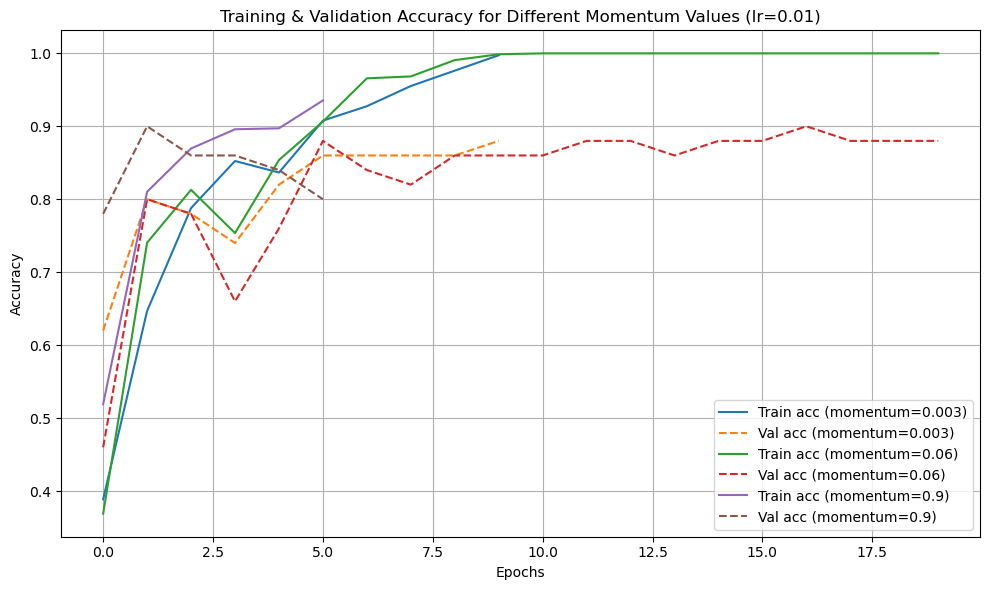

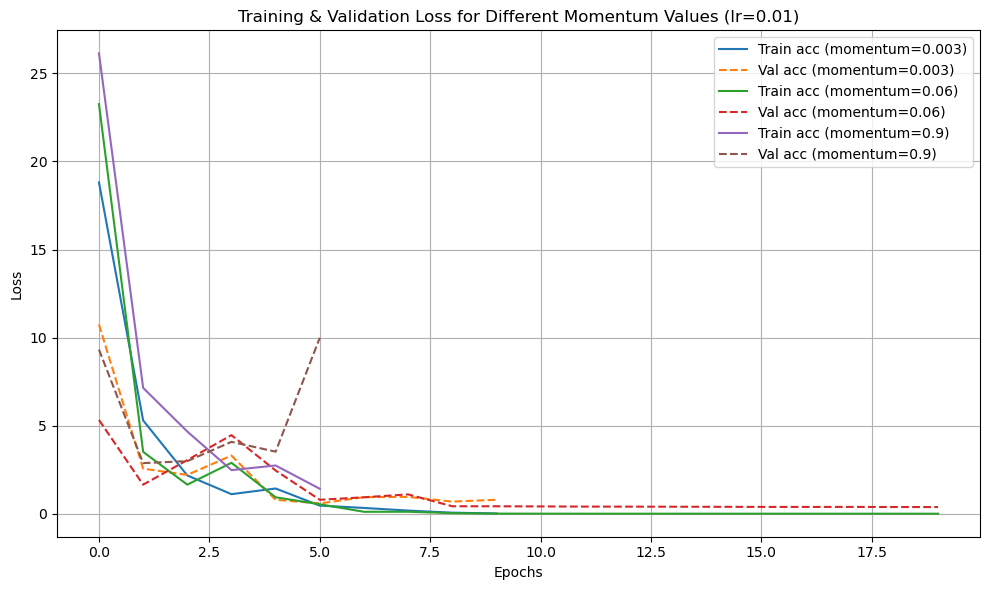

In [21]:
def plot_momentum_comparison(histories, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    for momentum, history in histories.items():
        plt.plot(history.history[metric], label=f'Train acc (momentum={momentum})')
        plt.plot(history.history[f'val_{metric}'], label=f'Val acc (momentum={momentum})', linestyle='--')
    plt.title(f'Training & Validation {metric.title()} for Different Momentum Values (lr=0.01)')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Accuracy
plot_momentum_comparison(momentum_histories, metric='accuracy')

# Loss
plot_momentum_comparison(momentum_histories, metric='loss')

### Report

The impact of varying momentum values in the SGD optimizer is significant with the learning rate of 0.01. Three different momentums of 0.003, 0.06, and 0.9 were used to test and observe how they influenced the model training and formalisation. As the output of task 12 showed, Momentum illustrated that momentum plays a crucial role in both convergence speed and stability. Looking at the momentum of 0.003, the model trained with a very slow rate compared to the other two momentum, and validation accuracy improved modestly, suggesting underfitting or conservative updates. While the 0.06 momentum gave the most stable and balanced performance, resulting in high training accuracy and consistently strong validation with low loss. While the momentum increased up to 0.9, the time this momentum reached 100% training accuracy was shorter than with lower momentum. The trade-off is unstable and fluctuating validation accuracy, which means a sign of overfitting.
| Momentum | Best Validation Accuracy  | Best Validation Loss    | Final Training Accuracy  | Observation |
|-------|-----------|-----------|-----------|-----------|
| 0.003     | 0.8200     | 1.0095     | 1.00     |Stable learning but moderate generalisation |
| 0.06     | 0.8600     | 0.6925     | 1.00     |Best balance of traning and validation |
| 0.9     | 0.8400     | 4.1870     | 1.00     |Overfitting; unstable validation loss |

These findings demonstrate that while higher momentum can accelerate convergence, it can also result in an instability if not correctly controlled. The momentum of 0.06 shows the most stable training accuracy and the most low loss compared with other two momentums.  Overall, tuning momentum is important for achieving effective learning without compromising generalisation performance. 

## Task 13
Now using “accelerated transfer learning”, repeat the training process (k-fold validation is optional this time). You should prepare your training, validation and test sets based on {(F(x1).t1), (F(x2),t2),...,(F(xm),tm)}, and re-do Task 12. 


In [22]:
# Load base model with frozen weights
base_model = ka.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

x_train, y_train = train_set
x_val, y_val = eval_set


x_train_features = feature_extractor.predict(x_train, batch_size=32)
x_val_features = feature_extractor.predict(x_val, batch_size=32)


#should be same performance but a 1/10 of the time

def accelerated_learning(x_train_features, y_train, 
                         x_val_features, y_val, 
                         parameters):
    '''
    Perform accelerated learning using precomputed features from a frozen base model.

    Parameters:
    - x_train_features: Features extracted from frozen base model (train set)
    - y_train: Training labels
    - x_val_features: Features extracted from frozen base model (validation set)
    - y_val: Validation labels
    - parameters: Tuple (learning_rate, momentum, nesterov)

    Returns:
    - model: Trained top classifier model
    - history: Training history
    '''

    learning_rate, momentum, nesterov = parameters

    # Define the custom top layers (classifier)
    model = Sequential([
        GlobalMaxPooling2D(input_shape=x_train_features.shape[1:]),
        Dense(5, activation='softmax')  # Assuming 5 classes
    ])

    # Compile the model
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=4,
        min_delta=0.001,  # minimum change to be considered improvement
        restore_best_weights=True,
        verbose=1
    )

    # Train the classifier
    history = model.fit(
        x_train_features, y_train,
        validation_data=(x_val_features, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

#save the preprocessed data so it doesnt have to complie every singal time 

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step



Plot and comment on the results and differences against the standard implementation of transfer learning. 

Epoch 1/20


/opt/conda/lib/python3.12/site-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3038 - loss: 13.4347 - val_accuracy: 0.4600 - val_loss: 10.8505
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5405 - loss: 7.3657 - val_accuracy: 0.7400 - val_loss: 2.2686
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 1.7730 - val_accuracy: 0.6600 - val_loss: 3.8037
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7711 - loss: 1.7560 - val_accuracy: 0.7800 - val_loss: 1.6884
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8813 - loss: 0.4532 - val_accuracy: 0.8800 - val_loss: 0.8737
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9382 - loss: 0.2636 - val_accuracy: 0.8400 - val_loss: 0.8204
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9241 - loss: 0.3194 - val_accuracy: 0.8800 - val_loss: 0.7945
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9258 - loss: 0.5810 - val_accuracy: 0.8600 - val_loss: 0.6757
E

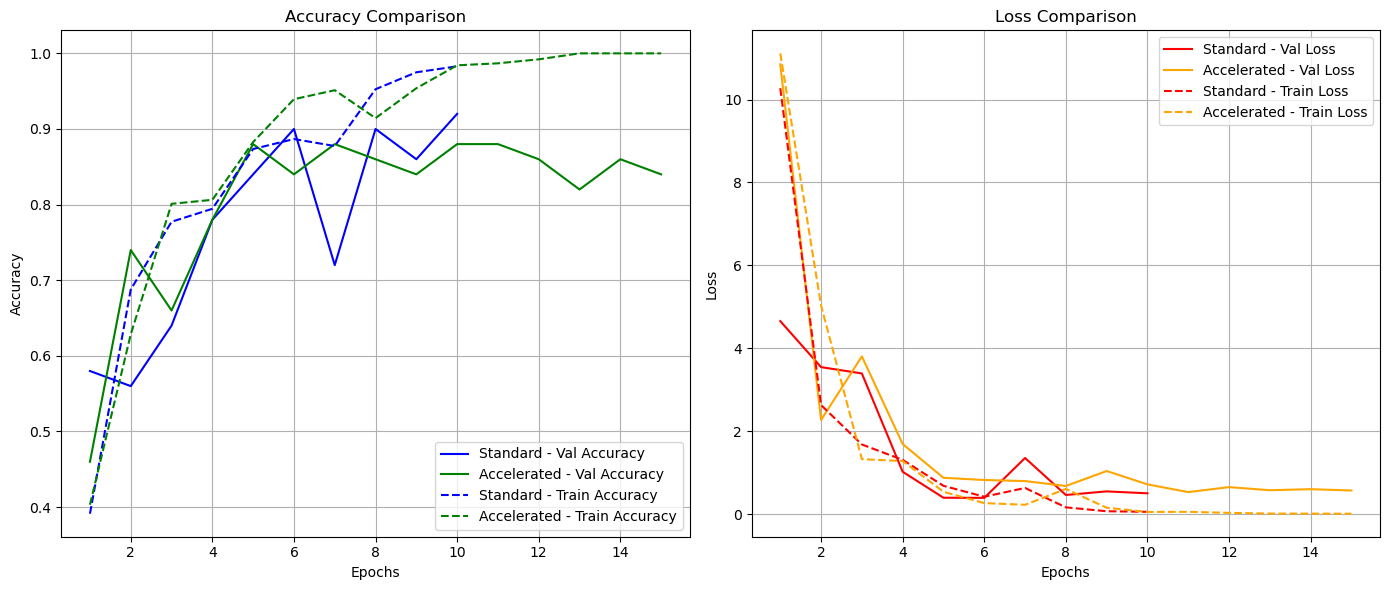

In [23]:
def compare_histories(history_standard, history_accelerated):
    epochs_standard = range(1, len(history_standard.history['accuracy']) + 1)
    epochs_accelerated = range(1, len(history_accelerated.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_standard, history_standard.history['val_accuracy'], 'b-', label='Standard - Val Accuracy')
    plt.plot(epochs_accelerated, history_accelerated.history['val_accuracy'], 'g-', label='Accelerated - Val Accuracy')
    plt.plot(epochs_standard, history_standard.history['accuracy'], 'b--', label='Standard - Train Accuracy')
    plt.plot(epochs_accelerated, history_accelerated.history['accuracy'], 'g--', label='Accelerated - Train Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    
    plt.plot(epochs_standard, history_standard.history['val_loss'], 'r-', label='Standard - Val Loss')
    plt.plot(epochs_accelerated, history_accelerated.history['val_loss'], 'orange', label='Accelerated - Val Loss')
    plt.plot(epochs_standard, history_standard.history['loss'], 'r--', label='Standard - Train Loss')
    plt.plot(epochs_accelerated, history_accelerated.history['loss'], 'orange', linestyle='--', label='Accelerated - Train Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


parameters = (0.01, 0.0, False)  # Example learning rate setup
model_accelerated, history_accelerated = accelerated_learning(
    x_train_features, y_train,
    x_val_features, y_val,
    parameters
)



#Aim: reduce the time and results similar to task 7
compare_histories(history_standard, history_accelerated)


As shown in the graphs, the results of the standard implementation of transfer learning and the accelerated transfer learning approach are relatively similar in terms of accuracy and performance. The main difference lies in the training time. In the standard transfer learning approach, the model processes the frozen layers during every training epoch. This results in redundant forward passes through the base network, significantly increasing training time. In contrast, the accelerated approach improves efficiency by extracting features from the frozen layers only once. These precomputed features are then reused during training of the custom layers, which are the only layers being updated. This optimization leads to much faster training while maintaining comparable performance. As a result, the accelerated method is more time-efficient without sacrificing model accuracy.

## Task 14
Use the results of all experiments to make suggestions for future work and recommendations for parameter values to anyone else who may be interested in a similar implementation of transfer learning. 

### Your answer:

Based on the results of this project, several recommendations can be made for optimizing similar transfer learning implementations. First, while the current approach kept the convolutional base frozen, future iterations could consider unfreezing the top few layers of the pre-trained model. This allows the model to fine tune high-level features specific to the flower dataset or any other dataset for that matter, improving classification performance. However, this comes at the cost of increased training time and a higher risk of overfitting, so a lower learning rate and early stopping should be used during fine tuning.

Secondly, data augmentation is highly recommended for future work. Augmentation techniques such as horizontal flips, rotations, zoom, and brightness adjustments introduce variability in the training set, helping the model generalize better to unseen data. This is particularly beneficial when the dataset size is small, as in this case. Further research suggests augmentations should be applied dynamically during training rather than statically to maximize their diversity. Dynamically applying augmentations ensures that the model is exposed to different variations of the same image in each epoch, which significantly improves generalization by preventing overfitting to a narrow set of transformations.

For training parameters, our experiments suggest that a learning rate of 0.015 for initial training, momentum of 0.06, and batch size of 32 offer stable convergence. While a batch size of 32 offers a balance between gradient stability and memory efficiency, increasing the batch size could further improve training and lead to faster convergence due to more accurate gradient estimates. Additionally, accelerated transfer learning using cached feature extraction significantly reduced training time while preserving model performance and is recommended when computational efficiency is a priority.